In [1]:
import tensorflow as tf

import tensorflow_addons as tfa

import matplotlib.pyplot as plt

import os 

import numpy as np

from tensorflow.data import AUTOTUNE

from PIL import Image, ImageFilter

In [2]:
# (xtrain,_), (xtest,_) = fashion_mnist.load_data()

In [3]:
data_dir = r"D:\digital_enhancement\images\training_images"
images = os.listdir(data_dir)
images_list = [data_dir + "/" + img for img in images]
image_count = len(images_list)

In [4]:
list_ds = tf.data.Dataset.list_files(images_list, shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [5]:
for f in list_ds.take(5):
  print(f.numpy())

b'D:\\digital_enhancement\\images\\training_images\\image1_559.jpg'
b'D:\\digital_enhancement\\images\\training_images\\image2_110.jpg'
b'D:\\digital_enhancement\\images\\training_images\\image2_476.jpg'
b'D:\\digital_enhancement\\images\\training_images\\image2_312.jpg'
b'D:\\digital_enhancement\\images\\training_images\\image3_13.jpg'


In [6]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [7]:
width = 640
height = 360
noise_factor = .2

In [8]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  img1 = tf.image.resize(img, [height, width])
  img1 = tf.cast(img1, tf.float32) / 255.
  img2 = tfa.image.gaussian_filter2d(img1, [5,5])
  # Resize the image to the desired size
  
  # Add gaussian noise
  noise_factor = .05
  img2 = img2 + noise_factor * ( tf.random.normal(shape=img2.shape)  )
  img2 = tf.clip_by_value(img2, clip_value_min=0., clip_value_max=1.) 
  
  return img1, img2

def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img1, img2 = decode_img(img)
  return img2, img1


train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [9]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(4)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

1.0
1.0
1.0
1.0


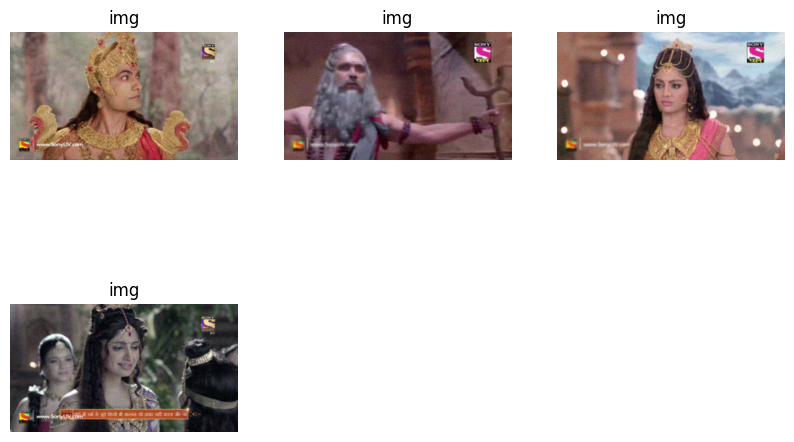

In [10]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(4):
  ax = plt.subplot(3, 3, i + 1)
  img = image_batch[i].numpy() 
  print(img.max())
  # img *= 255
  # i = i.astype("uint8")
  plt.imshow(img)
#   label = label_batch[i]
  plt.title("img")
  plt.axis("off")

In [11]:
# Build encoder decoder model using keras functional API

from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, UpSampling2D, GaussianNoise
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

def create_model():
  x = Input(shape=(height, width, 3))
# Encoder
  # noise = GaussianNoise(0.6)(x)
  e_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  pool1 = MaxPooling2D((2, 2), padding='same')(e_conv1)
  batchnorm_1 = BatchNormalization()(pool1)
  e_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
  pool2 = MaxPooling2D((2, 2), padding='same')(e_conv2)
  batchnorm_2 = BatchNormalization()(pool2)
  e_conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(batchnorm_2)
  h = MaxPooling2D((2, 2), padding='same')(e_conv3)
# Decoder
  d_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
  up1 = UpSampling2D((2, 2))(d_conv1)
  d_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
  up2 = UpSampling2D((2, 2))(d_conv2)
  d_conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(up2)
  up3 = UpSampling2D((2, 2))(d_conv3)
  r = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)
  
  model = Model(x, r)
  model.compile(optimizer='adam', loss='mse')
  return model
gaussian_auto_encoder = create_model()
gaussian_early_stop = EarlyStopping(monitor='loss', patience=3)

            
        


In [12]:
gaussian_history = gaussian_auto_encoder.fit(train_ds,validation_data= val_ds, epochs=200, batch_size=32, callbacks=[gaussian_early_stop])

Epoch 1/200
622/622 [==============================] - 60s 75ms/step - loss: 0.0133 - val_loss: 0.0079
Epoch 2/200
622/622 [==============================] - 40s 65ms/step - loss: 0.0068 - val_loss: 0.0052
Epoch 3/200
622/622 [==============================] - 40s 64ms/step - loss: 0.0060 - val_loss: 0.0043
Epoch 4/200
622/622 [==============================] - 40s 64ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 5/200
622/622 [==============================] - 40s 65ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 6/200
622/622 [==============================] - 40s 64ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 7/200
622/622 [==============================] - 40s 64ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 8/200
622/622 [==============================] - 40s 64ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 9/200
622/622 [==============================] - 40s 64ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 10/200
622/622 [==============================] - 40s 64ms/step - l

In [13]:
gaussian_auto_encoder.save("tfmodels/gaussian_auto_encoder.h5")

In [14]:
i = next(iter(val_ds))

In [15]:
i[0][:1].shape

TensorShape([1, 360, 640, 3])

In [16]:
o = gaussian_auto_encoder.predict(i[0][:1])
o = tf.clip_by_value(o[0], clip_value_min=0., clip_value_max=1.)

1/1 [==============================] - 2s 2s/step


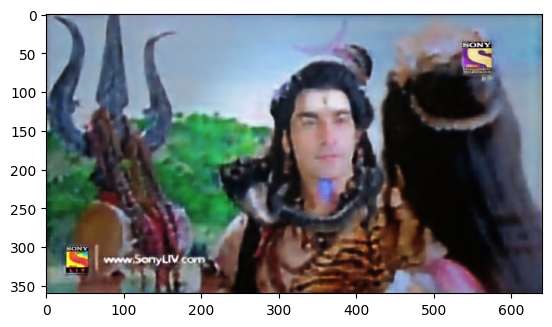

In [17]:
plt.imshow(o)

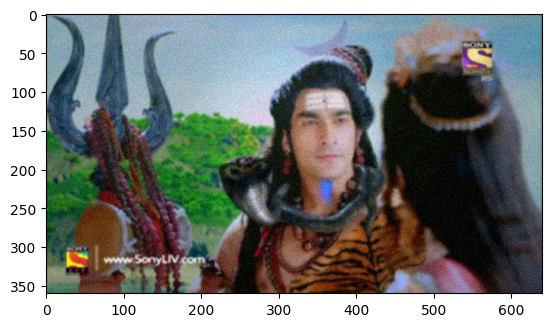

In [18]:
plt.imshow(i[0][0])

NameError: name 'x_test_noisy' is not defined

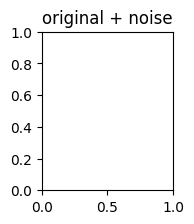

In [19]:
n = 10 
plt.figure(figsize=(20, 7))
plt.gray()

for i in range(n): 
  # display original + noise 
  bx = plt.subplot(3, n, i + 1) 
  plt.title("original + noise") 
  plt.imshow(tf.squeeze(x_test_noisy[i])) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 
  
  # display reconstruction 
  cx = plt.subplot(3, n, i + n + 1) 
  plt.title("reconstructed") 
  plt.imshow(tf.squeeze(decoded_imgs[i])) 
  bx.get_xaxis().set_visible(False) 
  bx.get_yaxis().set_visible(False) 
  
  # display original 
  ax = plt.subplot(3, n, i + 2*n + 1) 
  plt.title("original") 
  plt.imshow(tf.squeeze(x_test[i])) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 

plt.show()